In this notebook, I used Doc2vec to convert the article text into their numerical representation. Doc2vec provide the word embeddings so it can retain the meaning.

In [1]:
## Importing all the important libararies
import numpy as np
import pandas as pd

import re
import string
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from sklearn.utils import shuffle,resample


import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score 

import warnings
warnings.simplefilter(action='ignore')

C:\Users\Hardik\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [83]:
data_file = './data/news_data.csv'

In [84]:
## Load data into dataframe
news_df = pd.read_csv(data_file)

In [85]:
news_df.head()

,Unnamed: 0,author,country,crawled,domain_rank,facebook_comments,facebook_likes,language,main_image,participants_count,published,rating,site,site_categories,site_type,text,title,url,factual_reporting
0,0,Javier Moreno,US,2019-04-11T07:20:39.028+03:00,137.0,319,382,english,https://img.buzzfeed.com/buzzfeed-static/stati...,1,2019-04-11T12:14:00.000+03:00,NaN,www.buzzfeed.com,"['media', 'homework_study_tips', 'education']",blogs,Questions are coming. HBO Correct Incorrect Co...,"Which ""Game Of Thrones"" Group Do You Really Be...",https://www.buzzfeed.com/javiermoreno/game-of-...,Mixed
1,1,Political Reporter Jackson Gothe-Snape,AU,2019-04-11T07:25:13.024+03:00,1455.0,45,43,english,https://www.abc.net.au/news/image/9226414-16x9...,1,2019-04-11T03:00:00.000+03:00,NaN,www.abc.net.au,"['television', 'music', 'entertainment']",news,Australians are increasingly suspicious of gov...,Election to focus on economy but voters losing...,https://www.abc.net.au/news/2019-04-11/federal...,High
2,2,sports.yahoo.com,US,2019-04-11T07:35:44.051+03:00,137.0,0,0,english,https://img.buzzfeed.com/buzzfeed-static/stati...,1,2019-04-11T03:00:00.000+03:00,NaN,www.buzzfeed.com,"['media', 'homework_study_tips', 'education']",news,Share On facebook Share On facebook Compartilh...,Responda estas perguntas sobre sexo e adivinha...,https://www.buzzfeed.com/br/luisdelvalle/respo...,Mixed
3,3,Yoonjung Seo,US,2019-04-11T07:36:28.007+03:00,81.0,3031,24808,english,https://cdn.cnn.com/cnnnext/dam/assets/1904101...,1,2019-04-11T12:19:00.000+03:00,NaN,edition.cnn.com,['media'],news,Seoul (CNN) South Korea's 66-year abortion ban...,Will South Korea legalize abortion after 50-ye...,https://edition.cnn.com/2019/04/11/health/sout...,Mixed
4,4,Caroline Kelly,US,2019-04-11T07:36:45.001+03:00,81.0,5701,20690,english,https://cdn.cnn.com/cnnnext/dam/assets/1603211...,1,2019-04-11T12:24:00.000+03:00,NaN,edition.cnn.com,['media'],news,Washington (CNN) President Donald Trump's olde...,"Investigation into Maryanne Trump Barry, Presi...",https://edition.cnn.com/2019/04/11/politics/ma...,Mixed


In [86]:
news_df.shape

(34680, 19)

<a id='EDA'></a>

## Exploratory Data Analysis

In [87]:
news_df.isnull().sum()

Unnamed: 0                0
author                 7624
country                 426
crawled                   0
domain_rank            1768
facebook_comments         0
facebook_likes            0
language                  0
main_image             1183
participants_count        0
published                 0
rating                34680
site                      0
site_categories           0
site_type                 0
text                      0
title                  3005
url                       0
factual_reporting         0
dtype: int64

### It seems that unnamed is an extra column so we need to drop it and also rating value of each article is not available.So we need to drop both of them

In [88]:
news_df.drop(['Unnamed: 0','rating'],axis=1,inplace=True)

In [89]:
news_df.shape

(34680, 17)

In [90]:
#finding the columns having null values and data type is object
null_columns_with_dt_object = [col for col in news_df.columns if (news_df[col].isnull().sum()>0) & (news_df[col].dtype == np.object)]
null_columns_with_dt_object

['author', 'country', 'main_image', 'title']

In [91]:
#replacing the null values
for each_column in null_columns_with_dt_object:
    news_df[each_column].fillna('NA',inplace=True)
    

In [92]:
#replacing the null values for domain rank
news_df['domain_rank'].fillna(0,inplace=True)


In [93]:
#changing the country code to their corresponsing name
country_encoded_dict = {'US' :  'United States', 'AU' : 'Australia', 'JP' : 'Japan', 'CZ' : 'Czech Repulbic', 'GB' : 'United Kingdom(GB)', 'CA' : 'Canada', 
             'DE' : 'Germany', 'CC' : 'Cocos (Keeling) Islands', 'CH' : 'Switzerland', 'TK' : 'Tokelau', 'ID' :  'Indonesia',
             'BG' :  'Bulgaria','EU':'European Union','PH': 'Philippines','ML': 'Mali','IN':'India','NG':'Nigeria','TR':'Turkey',
            'MA': 'Morocco','LI': 'Liechtenstein','FR':'France','IT':'Italy','NL':'Netherlands','IL':'Israel','NA':'NA'}
news_df['country'] = news_df['country'].map(lambda x: country_encoded_dict[x])

In [94]:
# creating the copy of actual df and from now onwords we will work on this copy
news_df_new = news_df.copy()

### Removing all the duplicate articles

In [95]:
news_df_new.drop_duplicates(subset='title',inplace=True,keep='first')

In [96]:
news_df_new.shape

(26754, 17)

In [97]:
#No. of articles in each category after remoc=ving duplicate articles
news_df_new['factual_reporting'].value_counts()

High     12311
Mixed    12121
Low       2322
Name: factual_reporting, dtype: int64

In [98]:
news_df_new.isnull().sum()

author                0
country               0
crawled               0
domain_rank           0
facebook_comments     0
facebook_likes        0
language              0
main_image            0
participants_count    0
published             0
site                  0
site_categories       0
site_type             0
text                  0
title                 0
url                   0
factual_reporting     0
dtype: int64

### Look at how many articles are there other than English language and drop all those articles

In [99]:
news_df_new['language'].value_counts()

english       24460
arabic          936
spanish         643
japanese        525
portuguese      180
french            3
german            3
chinese           2
welsh             1
indonesian        1
Name: language, dtype: int64

In [100]:
news_df_new.drop(news_df_new[news_df_new['language'] != 'english'].index,inplace=True)
news_df_new.shape

(24460, 17)

In [101]:
# No of articles in each category after removing all non-english articles
news_df_new['factual_reporting'].value_counts()

High     12306
Mixed     9833
Low       2321
Name: factual_reporting, dtype: int64

In [102]:
#Minimum and maximum published date in data set
print("Minimum published date:", news_df_new['published'].min())
print("Maximum published date:", news_df_new['published'].max())


Minimum published date: 2019-04-10T02:29:00.000+03:00
Maximum published date: 2019-05-11T12:28:00.000+03:00


In [103]:
#baseline
news_df_new['factual_reporting'].value_counts(normalize=True)

High     0.503107
Mixed    0.402003
Low      0.094890
Name: factual_reporting, dtype: float64

In [104]:
custom_stop_words = ['correct','incorrect','']
stop_words = stopwords.words("english")
stop_words.extend(custom_stop_words)

### Working with Doc2vec

In [105]:
#Ths function is used to preprocess all the text to remove punctuation marks, converting text to lower case and removing numerical data
def preprocess_article(article_text_lines):
    article_tokens = []
    for line in sent_tokenize(article_text_lines):
        #tokenize words in each line
        for each_word in word_tokenize(line):
            #lower word
            each_word = each_word.lower()
            #remove non alphabets
            each_word = re.sub('[^a-zA-Z]','', each_word)
            #remove the punctuation mark
            each_word = re.sub(r'[^\w\s]','',each_word)
            article_tokens.append(each_word)
    article_tokens = [word for word in article_tokens if not word in stop_words]
    return article_tokens
    

In [106]:
#creatig a seprate dataframe having processed articles and type of articles(target) 
df_processed_article = pd.DataFrame({'processed_article': news_df_new['text'].apply(lambda x:preprocess_article(x)),\
                                     'factual_reporting': news_df_new['factual_reporting']})

In [107]:
df_processed_article.head()

,processed_article,factual_reporting
0,"[questions, coming, hbo, disney, disney, king,...",Mixed
1,"[australians, increasingly, suspicious, govern...",High
2,"[share, facebook, share, facebook, compartilha...",Mixed
3,"[seoul, cnn, south, korea, year, abortion, ban...",Mixed
4,"[washington, cnn, president, donald, trump, ol...",Mixed


In [50]:
#sentences = TaggedDocument(words=df_processed_article['processed_article'],tags=df_processed_article['factual_reporting'])

In [108]:
#tagging the articles with their corresponding type from factual reporting to used it for Doc2vec
tagged_sentences = df_processed_article.apply(lambda x: TaggedDocument(words=x['processed_article'],tags = [x['factual_reporting']]),axis=1)

### Generating Doc2vec model

In [109]:
#Building the vocabulary from the tagged data
def build_vocab(tagged_sentences):
    model_article_dbow = Doc2Vec(dm=1,vector_size=250,negative=5,min_count=1,alpha=0.025,min_alpha=0.00025)
    model_article_dbow.build_vocab([x for x in tqdm(tagged_sentences)])
    return model_article_dbow

In [110]:
model_article_dbow = build_vocab(tagged_sentences)

100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1019807.91it/s]


In [111]:
#train the Doc2vec model 
def train_doc2vec_model(tagged_sentences):
    for epoch in range(30):
        print('iteration {0}'.format(epoch))
        model_article_dbow.train(shuffle([x for x in tqdm(tagged_sentences)]),\
                             total_examples = len(tagged_sentences),epochs=1)
        model_article_dbow.alpha -= 0.02
        model_article_dbow.min_alpha = model_article_dbow.alpha
    model_article_dbow.save('d2v.model')
    return model_article_dbow

In [112]:
model_article_dbow = train_doc2vec_model(tagged_sentences)

iteration 0


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1631536.96it/s]


iteration 1


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1882814.44it/s]


iteration 2


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 661465.75it/s]


iteration 3


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1019757.23it/s]


iteration 4


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1439654.74it/s]


iteration 5


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 843932.68it/s]


iteration 6


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1439654.74it/s]


iteration 7


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1748192.48it/s]


iteration 8


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1288011.30it/s]


iteration 9


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 906447.87it/s]


iteration 10


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1359617.74it/s]


iteration 11


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1223701.37it/s]


iteration 12


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 815781.46it/s]


iteration 13


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 661482.81it/s]


iteration 14


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 941355.39it/s]


iteration 15


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 978993.80it/s]


iteration 16


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 627531.87it/s]


iteration 17


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 719827.37it/s]


iteration 18


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 509893.82it/s]


iteration 19


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 815794.43it/s]


iteration 20


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 741662.40it/s]


iteration 21


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1112465.45it/s]


iteration 22


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1112658.49it/s]


iteration 23


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1223759.76it/s]


iteration 24


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 874088.79it/s]


iteration 25


100%|████████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 661431.63it/s]


iteration 26


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1165441.80it/s]


iteration 27


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1748132.91it/s]


iteration 28


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1529795.50it/s]


iteration 29


100%|███████████████████████████████████████████████████████████████████████| 24460/24460 [00:00<00:00, 1223701.37it/s]


In [113]:
#generating the vectors from the trained Doc2vec model
def vector_for_learning(model, input_docs):
    sents = input_docs
    #print(sents)
    targets, feature_vectors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=50)) for doc in sents])
    return targets, feature_vectors

In [114]:
model_article_dbow.corpus_total_words

8045321

In [115]:
#vector_for_learning(model_article_dbow,tagged_sentences)
len(model_article_dbow.infer_vector(tagged_sentences[0].words,steps=10))

250

In [116]:
#generting the features and target vectors from trained Doc2vec model
targets,article_vectors_dbow = vector_for_learning(model_article_dbow, tagged_sentences)

In [117]:
y = targets
X = article_vectors_dbow

In [120]:
#generate test-train split
def create_test_train_split(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=43,test_size=0.33,shuffle=True)
    return X_train,X_test,y_train,y_test

In [121]:
def generate_model_result(model_obj,X,y):
    X_train,X_test,y_train,y_test = create_test_train_split(X,y)
#    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    model = model_obj.fit(X_train,y_train)
    training_score = model.score(X_train,y_train)
    testing_score = model.score(X_test,y_test)
    cv_train_score = np.mean(cross_val_score(model,X_train,y_train,cv=5,n_jobs=3))
    cv_test_score = np.mean(cross_val_score(model,X_test,y_test,cv=5,n_jobs=3))
    y_pred = model.predict(X_test)
    return training_score,testing_score,cv_train_score,cv_test_score,y_pred,y_test

### Applying Logistic Regression on Doc2vec vectors

In [122]:
lr=LogisticRegression(C=0.01,penalty='l1',random_state=43)

In [123]:
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(lr,X,y)

In [124]:
training_score , testing_score ,cv_train_score,cv_test_score 

(0.7008786917256529,
 0.7015609514370664,
 0.6978893476750032,
 0.6935080430137228)

In [125]:
def genrate_classificatoin_report(y_test,y_pred):
    print(classification_report(y_test,y_pred))

In [126]:
def generate_confusion_matrix(y_test,y_pred):
    class_names=['High','Low','Mixed'] 
    cnf_matrix = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots()

    sns.heatmap(pd.DataFrame(cnf_matrix,columns=['High','Low','Medium'],index=['High','Low','Medium']), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [127]:
genrate_classificatoin_report(y_test,y_pred)

              precision    recall  f1-score   support

        High       0.73      0.83      0.78      4090
         Low       0.51      0.04      0.07       757
       Mixed       0.66      0.70      0.68      3225

   micro avg       0.70      0.70      0.70      8072
   macro avg       0.63      0.52      0.51      8072
weighted avg       0.68      0.70      0.67      8072



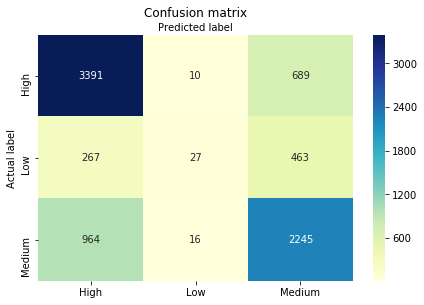

In [128]:
generate_confusion_matrix(y_test,y_pred)

### Resample the low class to handle class imbalancem

In [129]:
## Function to upsampale the low class
def upsample_class(news_data_df):
    df_low = news_data_df[news_data_df['factual_reporting']=='Low']
    df_mixed = news_data_df[news_data_df['factual_reporting']=='Mixed']
    df_high = news_data_df[news_data_df['factual_reporting']=='High']  
    
   

    df_low_upsampled = resample(df_low, 
                                     replace=True,     # sample with replacement
                                     n_samples=9000,    # to match majority class
                                     random_state=47) # reproducible results

    df_news_data_upsampled = pd.concat([df_high,df_mixed,df_low_upsampled])
 
    return df_news_data_upsampled

In [130]:
df_news_data_upsampled = upsample_class(news_df_new)

In [131]:
news_df_new.shape

(24460, 17)

In [132]:
df_news_data_upsampled.shape

(31139, 17)

In [133]:
df_upsampled_processed_article = pd.DataFrame({'processed_article': df_news_data_upsampled['text'].apply(lambda x:preprocess_article(x)),\
                                     'factual_reporting': df_news_data_upsampled['factual_reporting']})

In [134]:
df_upsampled_processed_article.head()

,processed_article,factual_reporting
1,"[australians, increasingly, suspicious, govern...",High
6,"[faqs, sorry, browser, needs, javascript, use,...",High
13,"[map, australia, shade, thursday, scott, morri...",High
14,"[map, australia, choice, voters, federal, elec...",High
15,"[could, dealt, outside, harsh, adversarial, wo...",High


In [135]:
tagged_sentences_upsampled = df_upsampled_processed_article.apply(lambda x: TaggedDocument(words=x['processed_article'],tags = [x['factual_reporting']]),axis=1)

In [136]:
model_article_dbow_upsampled = build_vocab(tagged_sentences_upsampled)

100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1112661.50it/s]


In [137]:
model_article_dbow_upsampled = train_doc2vec_model(tagged_sentences_upsampled)

iteration 0


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1639733.74it/s]


iteration 1


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1298223.06it/s]


iteration 2


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1298171.44it/s]


iteration 3


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1730964.07it/s]


iteration 4


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1557861.47it/s]


iteration 5


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1298184.34it/s]


iteration 6


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1198345.08it/s]


iteration 7


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1639795.50it/s]


iteration 8


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1557749.99it/s]


iteration 9


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1639774.92it/s]


iteration 10


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1416233.10it/s]


iteration 11


100%|████████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 708116.55it/s]


iteration 12


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1416340.60it/s]


iteration 13


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1832815.50it/s]


iteration 14


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1246208.91it/s]


iteration 15


100%|████████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 724580.90it/s]


iteration 16


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1298197.25it/s]


iteration 17


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1416125.60it/s]


iteration 18


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1416187.03it/s]


iteration 19


100%|████████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 890144.37it/s]


iteration 20


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1557768.57it/s]


iteration 21


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1557824.31it/s]


iteration 22


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1730941.13it/s]


iteration 23


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1416202.38it/s]


iteration 24


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1354627.73it/s]


iteration 25


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1198323.09it/s]


iteration 26


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1483573.95it/s]


iteration 27


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1639857.27it/s]


iteration 28


100%|███████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 1557842.89it/s]


iteration 29


100%|████████████████████████████████████████████████████████████████████████| 31139/31139 [00:00<00:00, 973650.35it/s]


In [138]:
model_article_dbow_upsampled.corpus_total_words

8045321

In [139]:
targets_upsampled,article_vectors_dbow_upsampled = vector_for_learning(model_article_dbow_upsampled, tagged_sentences_upsampled)

In [140]:
y_upsampled = targets_upsampled
X_upsampled = article_vectors_dbow_upsampled

In [146]:
lr=LogisticRegression(C=100,penalty='l2',random_state=43)

In [147]:
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(lr,X_upsampled,y_upsampled)

In [148]:
training_score , testing_score ,cv_train_score,cv_test_score

(0.6740162009298759, 0.6698131568703776, 0.6686008275916191, 0.676528035274021)

In [149]:
genrate_classificatoin_report(y_test,y_pred)

              precision    recall  f1-score   support

        High       0.72      0.77      0.74      4139
         Low       0.63      0.61      0.62      2967
       Mixed       0.64      0.59      0.62      3170

   micro avg       0.67      0.67      0.67     10276
   macro avg       0.66      0.66      0.66     10276
weighted avg       0.67      0.67      0.67     10276



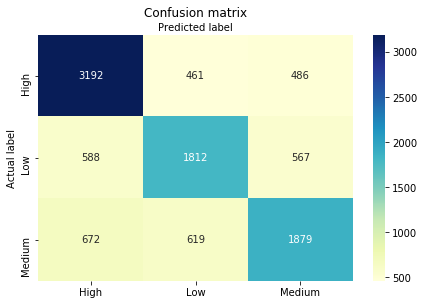

In [150]:
generate_confusion_matrix(y_test,y_pred)

### Random forest classification

In [176]:
forest_clf=RandomForestClassifier(n_estimators=30,max_depth=10,random_state=43,criterion='entropy', \
                                 max_features=10)

In [177]:
training_score , testing_score ,cv_train_score,cv_test_score,y_pred,y_test = generate_model_result(forest_clf,X_upsampled,y_upsampled)

In [178]:
training_score , testing_score ,cv_train_score,cv_test_score

(0.763169246992283, 0.6563838069287661, 0.6523019761623957, 0.6515163860992764)

In [179]:
genrate_classificatoin_report(y_test,y_pred)

              precision    recall  f1-score   support

        High       0.71      0.76      0.73      4139
         Low       0.59      0.65      0.62      2967
       Mixed       0.64      0.54      0.58      3170

   micro avg       0.66      0.66      0.66     10276
   macro avg       0.65      0.65      0.65     10276
weighted avg       0.66      0.66      0.65     10276



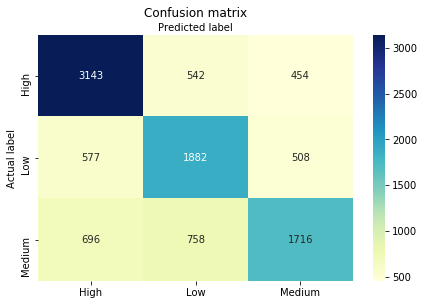

In [169]:
generate_confusion_matrix(y_test,y_pred)